In [1]:
import h5py
import matplotlib
import numpy
import scipy
import pandas as pd
import xarray
import netCDF4

In [2]:
"""
main.py
=======
The core file to run the CFM from the command line. This file creates classes 
for the spin up and main runs, and it runs the model. This can be bypassed if
you write your own script to call firn_density_spin and firn_density_nospin.py

Copyright © 2021 C. Max Stevens

Distributed under terms of the MIT license.
"""

import sys
import os
# from firn_density_spin import FirnDensitySpin
from firn_density_nospin import FirnDensityNoSpin
import time
import json
import shutil
import RCMpkl_to_spin as RCM

__author__ = "C. Max Stevens, Vincent Verjans, Brita Horlings, Annika Horlings, Jessica Lundin"
__license__ = "MIT"
__version__ = "1.1.0"
__maintainer__ = "Max Stevens"
__email__ = "maxstev@umd.edu"
__status__ = "Production"



In [3]:
false = False
true = True
d = {
"InputFileFolder": "CFMinput",
"InputFileNameTemp": "example_tskin.csv",
"InputFileNamebdot": "example_smb.csv",
"InputFileNameIso": "example_isotope.csv",
"InputFileNamerho": "example_rhos.csv",
"InputFileNamemelt": "example_melt.csv",
"resultsFolder": "CFMoutput",
"initfirnFile": "example_firndata.csv",
"initprofile": false,
"input_type": "dataframe",
"input_type_options": ["csv","dataframe"],
"DFresample": "1M",
"DFfile": "MERRA2_CLIM_df_72.5_-38.75.pkl",
"physRho": "KuipersMunneke2015",
"physRho_options":["HLdynamic","HLSigfus","Li2004","Li2011","Helsen2008","Arthern2010S","Arthern2010T","Li2015","Goujon2003","Barnola1991","Morris2014","KuipersMunneke2015","Crocus","Ligtenberg2011"],
"MELT": false,
"ReehCorrectedT": false,
"FirnAir": false,
"AirConfigName": "AirConfig.json",
"TWriteInt": 1,
"TWriteStart": 1980.0,
"int_type": "nearest",
"int_type_options": ["nearest","linear"],
"SeasonalTcycle": false,
"SeasonalThemi": "north",
"coreless": true,
"TAmp":10.0,
"physGrain": true,
"calcGrainSize": false,
"GrGrowPhysics": "Arthern",
"GrGrowPhysics_options": ["Arthern", "Katsushima"],
"heatDiff": true,
"conductivity": "Calonne2019",
"conductivity_options": ["Schwander","Yen_fixed","Yen_var","Anderson","Yen_b","Sturm","VanDusen","Schwerdtfeger","Riche","Jiawen","mix","Calonne2011","Calonne2019"],
"variable_srho": false,
"srho_type": "userinput",
"srho_type_options": ["userinput","param","noise"],
"rhos0": 350.0,
"r2s0": 1.0e-8,
"AutoSpinUpTime": false,
"yearSpin": 20,
"H": 3000,
"HbaseSpin": 2880.0,
"stpsPerYear": 12.0,
"D_surf": 1.0,
"bdot_type": "mean",
"bdot_type_options": ["instant","mean","stress"],
"grid_outputs": true,
"grid_output_res": 0.25,
"isoDiff": false,
"iso": "NoDiffusion",
"isoOptions":["18","D","NoDiffusion"],
"spacewriteint": 1,
"strain": false,
"du_dx": 1e-5,
"outputs": ["density", "depth", "temperature", "age", "DIP"],
"outputs_options": ["density", "depth", "temperature", "age", "Dcon", "bdot_mean", "climate", "compaction", "grainsize", "temp_Hx", "isotopes", "BCO", "DIPc", "DIP", "LWC","gasses", "PLWC_mem", "viscosity", "runoff", 
"refrozen"],
"resultsFileName": "CFMresults.hdf5",
"spinFileName": "CFMspin.hdf5",
"doublegrid": true,
"nodestocombine": 3,
"multnodestocombine": 12,
"grid1bottom": 5.0,
"grid2bottom": 15.0,
"spinup_climate_type": "mean",
"spinup_climate_type_options": ["mean", "initial"],
"manual_climate": false,
"deepT": 255.88,
"bdot_long": 0.49073,
"manual_iceout": false,
"iceout": 0.23,
"QMorris": 110.0e3,
"timesetup": "exact",
"timesetup_options": ["exact","interp","retmip"],
"liquid": "percolation_bucket",
"liquid_options": ["percolation_bucket","bucketVV","resingledomain","prefsnowpack"],
"merging": false,
"merge_min": 1e-4,
"LWCcorrect": false,
"manualT": false,
"no_densification": false,
"rad_pen": false,
"site_pressure": 1013.25,
"output_bits": "float32",
"spinUpdate": true,
"spinUpdateDate": 1980.0,
"DIPhorizon": 100.0,
"NewSpin": false
}


In [4]:
if __name__ == '__main__':
    """

    configName2 = os.path.join("/usr/local/cfm/CFM_main/", "example.json")
    print(configName2)
    if len(sys.argv) >= 2:
        configName = os.path.join(os.path.dirname(__file__), sys.argv[1])
        print(configName)
    else:
        print('No .json configuration file specified. Exiting.')
        sys.exit()
        # configName = os.path.join(os.path.dirname(__file__), 'generic.json')

    with open(configName, "r") as f:
        jsonString = f.read()
        c = json.loads(jsonString)

    """
    configName = "example.json"

    c = d
    tic=time.time()

    print("")
    print("-----------------------------------------------------------------------")
    print("-----------------------------------------------------------------------")
    print("<<<<<<<< Running the Community Firn Model (CFM), Version %s >>>>>>>>" %__version__)
    print("<<<<<<<< Please cite your use:                                 >>>>>>>>")
    print("<<<<<<<< https://doi.org/10.5194/gmd-13-4355-2020              >>>>>>>>")
    print("<<<<<<<< Distributed under terms of the MIT license.           >>>>>>>>")
    print("<<<<<<<< Please consider telling us that you are using the CFM >>>>>>>>")
    print("<<<<<<<< (it helps to keep the project going!)                 >>>>>>>>")
    print("<<<<<<<< Questions/comments to Max Stevens: maxstev@umd.edu    >>>>>>>>")
    print("-----------------------------------------------------------------------")
    print("-----------------------------------------------------------------------")
    print("")
    





-----------------------------------------------------------------------
-----------------------------------------------------------------------
<<<<<<<< Running the Community Firn Model (CFM), Version 1.1.0 >>>>>>>>
<<<<<<<< Please cite your use:                                 >>>>>>>>
<<<<<<<< https://doi.org/10.5194/gmd-13-4355-2020              >>>>>>>>
<<<<<<<< Distributed under terms of the MIT license.           >>>>>>>>
<<<<<<<< Please consider telling us that you are using the CFM >>>>>>>>
<<<<<<<< (it helps to keep the project going!)                 >>>>>>>>
<<<<<<<< Questions/comments to Max Stevens: maxstev@umd.edu    >>>>>>>>
-----------------------------------------------------------------------
-----------------------------------------------------------------------



In [5]:
    if '-n' in sys.argv:
        NewSpin = True
    elif 'NewSpin' in c:
        NewSpin = c['NewSpin']
    else:
        NewSpin = False

    if 'input_type' not in c:
        c['input_type'] = "csv"

#    print ("parameters: = ", c)
    print ("input folder = ", c['InputFileFolder'])
   
    if c['input_type'] == 'dataframe':
        pkl_name = os.path.join(c['InputFileFolder'],c['DFfile'])
        print (pkl_name)
        df_CLIM = pd.read_pickle(pkl_name)
        print (df_CLIM)
        timeres = c['DFresample']
        climateTS, stepsperyear, depth_S1, depth_S2, desired_depth = RCM.makeSpinFiles(pkl_name,timeres = timeres, melt = c['MELT'])
    else:
        climateTS = None
    
    tic=time.time()
    firn = FirnDensityNoSpin(configName, climateTS = climateTS, NewSpin = NewSpin)
    firn.time_evolve()

    shutil.copy(configName,c['resultsFolder'])
    
    print ("output folder = ", c['resultsFolder'])

    print('run time =' , time.time()-tic , 'seconds')



input folder =  CFMinput
CFMinput/MERRA2_CLIM_df_72.5_-38.75.pkl
                          TSKIN      BDOT
time                                     
1980-01-01 00:30:00  241.972900  0.043170
1980-01-01 01:30:00  241.077454  0.027385
1980-01-01 02:30:00  239.971497  0.017998
1980-01-01 03:30:00  238.646576  0.012895
1980-01-01 04:30:00  237.417847  0.011574
...                         ...       ...
2020-12-31 19:30:00  250.290894  0.165975
2020-12-31 20:30:00  251.203064  0.281096
2020-12-31 21:30:00  251.545471  0.180888
2020-12-31 22:30:00  251.140015  0.058284
2020-12-31 23:30:00  250.416870  0.043733

[359424 rows x 2 columns]
Main run starting
physics are KuipersMunneke2015
modeltime 1980.1612021857923 2020.9972677595629
output folder =  CFMoutput
run time = 1.343599796295166 seconds


### Plot results

In [6]:
import matplotlib.pyplot as plt

In [7]:
matplotlib.rcParams['axes.formatter.useoffset'] = False
matplotlib.rcParams.update({'figure.autolayout': True})
fontsz = 20
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rcParams['axes.titlesize'] = 22
plt.rcParams["axes.labelsize"] = 22
plt.rcParams["legend.fontsize"] = 16
plt.rcParams['figure.figsize'] = [12, 10]
mplcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [8]:
rfolder = 'CFMoutput/' # This may need to be altered
rfile = 'CFMresults.hdf5'
fpath = os.path.join(rfolder,rfile)
f = h5py.File(fpath,'r')
timesteps = f['density'][1:,0]
stps = len(timesteps)
depth = f['depth'][1:]
density = f['density'][1:,1:]
dip_all = f['DIP'][1:,1:]
f.close()
dH = dip_all[:,-2]
deltaFAC = dip_all[:,0]-dip_all[0,0]

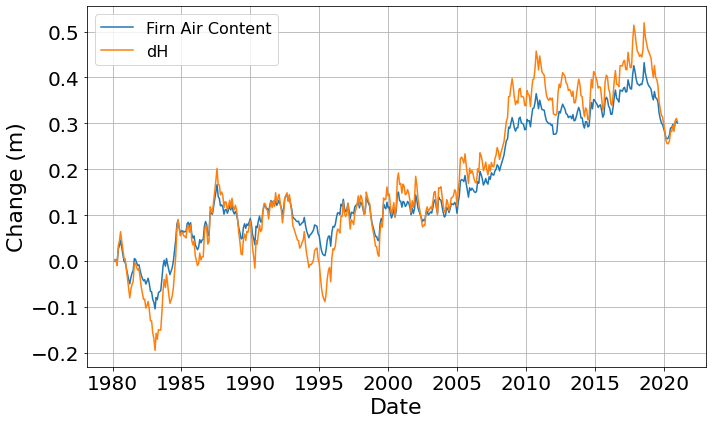

In [9]:
f2,a2 = plt.subplots(figsize=(10,6))
a2.plot(timesteps,deltaFAC,color = mplcolors[0],label='Firn Air Content')
a2.plot(timesteps,dH,color=mplcolors[1],label='dH')
a2.grid(True);
a2.set_ylabel('Change (m)');
a2.set_xlabel('Date');
a2.legend();

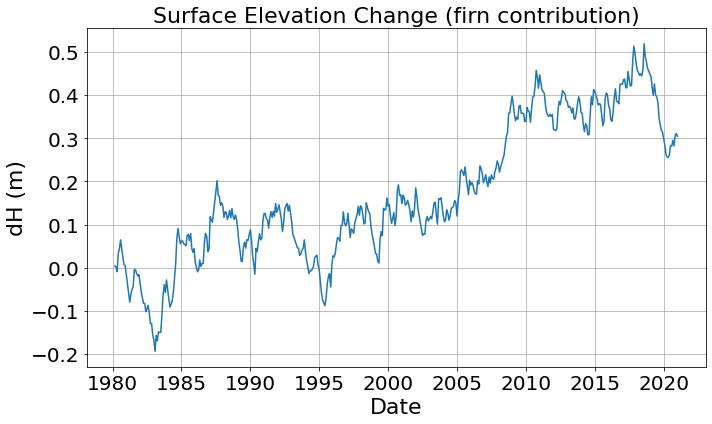

In [10]:
f2,a2 = plt.subplots(figsize=(10,6))
a2.plot(timesteps,dH)
a2.grid(True)
a2.set_title('Surface Elevation Change (firn contribution)');
a2.set_ylabel('dH (m)');
a2.set_xlabel('Date');

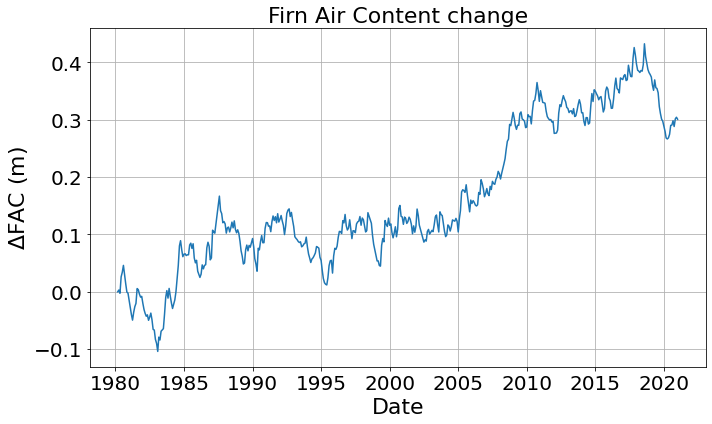

In [11]:
f2,a2 = plt.subplots(figsize=(10,6))
a2.plot(timesteps,deltaFAC)
a2.grid(True)
a2.set_title('Firn Air Content change');
a2.set_ylabel('$\Delta$FAC (m)');
a2.set_xlabel('Date');

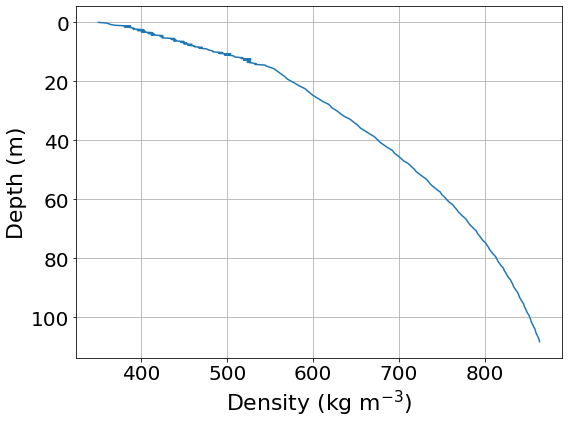

In [12]:
f1,a1 = plt.subplots(figsize=(8,6))
a1.plot(density[-1,:],depth)
a1.invert_yaxis()
a1.grid(True)
a1.set_ylabel('Depth (m)')
a1.set_xlabel(r'Density (kg m$^{-3}$)');